In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update(
    {
        # ── Canvas size & resolution ───────────────────────────────────────────
        # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
        "figure.figsize": (12, 8),
        "figure.dpi": 200,  # crisp in-notebook / retina preview
        "savefig.dpi": 400,  # print-quality PNG/PDF
        # ── Fonts ──────────────────────────────────────────────────────────────
        "font.family": "sans-serif",
        "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
        "axes.titlesize": 24,
        # "axes.titleweight": "bold",
        "axes.labelsize": 24,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 20,
        # ── Axis & spine aesthetics ────────────────────────────────────────────
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.linewidth": 1,
        "axes.grid": True,
        "grid.color": "#E6E6E6",
        "grid.linewidth": 0.4,
        "grid.alpha": 0.8,
        # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
        "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),
        # ── Figure background ─────────────────────────────────────────────────
        "figure.facecolor": "white",
    }
)

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",  # slightly larger fonts for presentations / papers
    style="whitegrid",  # grid only on y-axis (good for histograms)
    palette="Set2",  # matches the rcParams colour cycle
)


# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=True, **savefig_kwargs)


# 4.  Colour constants for this project (optional convenience)
COL_RAW = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF = "0.35"  # census reference (neutral grey)

In [3]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/athletes_brain/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/athletes_brain/figures/fig1")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" / "atlases" / ATLAS / "parcels.csv", index_col=0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [4]:
metrics = ["gm_vol", "wm_vol", "csf_vol", "adc", "fa", "ad", "rd"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
        drop=True
    )
    data[metric] = data[metric].drop_duplicates(subset=["subject_code", region_col], keep="last")
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})


# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_1547262/1475841652.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1547262/1475841652.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1547262/1475841652.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1547262/1475841652.py:9: DtypeWarning: Columns (16,23,24,25,26,27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0

In [5]:
metric_cols = {metric: "volume" if "vol" in metric else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df

In [6]:
# --- 1. Initial Setup and Imports ---

# Standard libraries
import os
import pandas as pd
import numpy as np

# Statistical analysis
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning (for potential future steps like classification)
# from sklearn.model_selection import train_test_split, cross_val_score # Not directly used in this section
# from sklearn.svm import SVC # Not directly used in this section
# from sklearn.metrics import classification_report, confusion_matrix # Not directly used in this section

# For multiple comparisons correction (will be used later)
from statsmodels.stats.multitest import multipletests

In [7]:
# --- 3. Univariate Group Comparisons (ANCOVA) - Adapted for Dictionary ---

print("\n--- Starting Univariate Group Comparisons (ANCOVA) ---")

# Define your group labels from the 'group' column
control_group_label = "Control"
climber_group_label = "Climber"
bjj_group_label = "BJJ"

# Store results for all comparisons
athletes_vs_naive_results = {}

# Loop through each MRI metric type in your dictionary
for metric_type, df_metric in data.items():
    print(f"\n--- Analyzing Metric: {metric_type} ---")

    # Define covariates for the current metric. TIV is only for volumetric measures.
    current_covariates = ["age_at_scan", "sex"]
    if "vol" in metric_type and "tiv" in df_metric.columns:
        current_covariates.append("tiv")

    # --- Comparison 1: Athlete (True) vs. Control (False) using 'target' column ---
    print(f"  Performing Athlete vs. Control comparison for {metric_type}...")
    # temp_df_target = df_metric[["target"] + current_covariates].copy()
    temp_df_target = df_metric.copy()  # Use the full DataFrame for region columns
    # temp_df_target.dropna(inplace=True)
    temp_df_target["target"] = temp_df_target["target"].astype(
        str
    )  # Ensure 'target' is treated as categorical

    if temp_df_target.empty or len(temp_df_target["target"].unique()) < 2:
        print(f"    Skipping Athlete vs. Control for {metric_type}: Not enough data or groups.")
    else:
        metric_stats = parcels.copy()
        for i, row in metric_stats.iterrows():
            cur_df = temp_df_target[temp_df_target[region_col] == row[region_col]]
            formula_parts = ["value ~ C(target)"] + current_covariates
            formula = " + ".join(formula_parts)
            # break
            try:
                # model = ols(formula, data=cur_df).fit()
                # do wls with weights to correct the imbalance in group sizes
                groups_ratio = cur_df["target"].value_counts(normalize=True).to_dict()
                # put more weights on the smaller group, so we need to invert the ratio
                groups_ratio = {k: 1 / v for k, v in groups_ratio.items()}

                weights = cur_df["target"].map(groups_ratio)
                model = wls(formula, data=cur_df, weights=weights).fit()
                aov_table = sm.stats.anova_lm(model, typ=2)
                group_p_value = aov_table.loc["C(target)", "PR(>F)"]
                group_f_statistic = aov_table.loc["C(target)", "F"]

                # Raw means for plotting
                group_means = cur_df.groupby("target")["value"].mean().to_dict()
                metric_stats.loc[i, "F_statistic"] = group_f_statistic
                metric_stats.loc[i, "p_value"] = group_p_value
                metric_stats.loc[i, "True_Mean"] = group_means.get("True", np.nan)
                metric_stats.loc[i, "False_Mean"] = group_means.get("False", np.nan)
                metric_stats.loc[i, "coefficient"] = model.params.get("C(target)[T.True]", np.nan)
                metric_stats.loc[i, "std_err"] = model.bse.get("C(target)[T.True]", np.nan)
                metric_stats.loc[i, "t_statistic"] = model.tvalues.get("C(target)[T.True]", np.nan)

            except Exception as e:
                # print(f"    Error processing {metric_type} - {region_col} (Athlete vs Control): {e}")
                # Append NaN for failed models to maintain order for p-value correction
                raise e
            metric_stats["adjusted_p_value"] = multipletests(
                metric_stats["p_value"], method="fdr_bh"
            )[1]
            athletes_vs_naive_results[metric_type] = metric_stats


--- Starting Univariate Group Comparisons (ANCOVA) ---

--- Analyzing Metric: gm_vol ---
  Performing Athlete vs. Control comparison for gm_vol...

--- Analyzing Metric: wm_vol ---
  Performing Athlete vs. Control comparison for wm_vol...

--- Analyzing Metric: csf_vol ---
  Performing Athlete vs. Control comparison for csf_vol...


/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not ha


--- Analyzing Metric: adc ---
  Performing Athlete vs. Control comparison for adc...

--- Analyzing Metric: fa ---
  Performing Athlete vs. Control comparison for fa...

--- Analyzing Metric: ad ---
  Performing Athlete vs. Control comparison for ad...

--- Analyzing Metric: rd ---
  Performing Athlete vs. Control comparison for rd...


In [8]:
# --- 3. Univariate Group Comparisons (ANCOVA) - Adapted for Dictionary ---

print("\n--- Starting Univariate Group Comparisons (ANCOVA) ---")

# Define your group labels from the 'group' column
control_group_label = "Control"
climber_group_label = "Climbing"
bjj_group_label = "Bjj"

# Store results for all comparisons
sports_vs_naive_results = {}

# Loop through each MRI metric type in your dictionary
for sport in [climber_group_label, bjj_group_label]:
    print(f"\n--- Analyzing Sport: {sport} ---")
    sports_vs_naive_results[sport] = {}
    for metric_type, df_metric in data.items():
        print(f"\n--- Analyzing Metric: {metric_type} ---")

        # Define covariates for the current metric. TIV is only for volumetric measures.
        current_covariates = ["age_at_scan", "sex"]
        if "vol" in metric_type and "tiv" in df_metric.columns:
            current_covariates.append("tiv")

        # --- Comparison 1: Athlete (True) vs. Control (False) using 'target' column ---
        print(f"  Performing {sport} vs. Control comparison for {metric_type}...")
        # temp_df_target = df_metric[["target"] + current_covariates].copy()
        temp_df_target = df_metric.copy()
        # drop the rows where the group is not in the current sport
        temp_df_target = temp_df_target.drop(
            temp_df_target[(temp_df_target["target"]) & (temp_df_target["group"] != sport)].index
        )
        # temp_df_target.dropna(inplace=True)
        temp_df_target["target"] = temp_df_target["target"].astype(
            str
        )  # Ensure 'group' is treated as categorical

        if temp_df_target.empty or len(temp_df_target["target"].unique()) < 2:
            print(
                f"    Skipping {sport} vs. Control for {metric_type}: Not enough data or groups."
            )
        else:
            metric_stats = parcels.copy()
            for i, row in metric_stats.iterrows():
                cur_df = temp_df_target[temp_df_target[region_col] == row[region_col]]
                # in the formula, make sure the reference group is "Climbing"
                formula_parts = ["value ~ C(target)"] + current_covariates
                formula = " + ".join(formula_parts)
                # break
                try:
                    # model = ols(formula, data=cur_df).fit()
                    # do wls with weights to correct the imbalance in group sizes
                    groups_ratio = cur_df["target"].value_counts(normalize=True).to_dict()
                    # put more weights on the smaller group, so we need to invert the ratio
                    groups_ratio = {k: 1 / v for k, v in groups_ratio.items()}
                    weights = cur_df["target"].map(groups_ratio)
                    model = wls(formula, data=cur_df, weights=weights).fit()
                    # Perform ANOVA to get F-statistic and p-value
                    aov_table = sm.stats.anova_lm(model, typ=2)
                    group_p_value = aov_table.loc["C(target)", "PR(>F)"]
                    group_f_statistic = aov_table.loc["C(target)", "F"]

                    # Raw means for plotting
                    group_means = cur_df.groupby("group")["value"].mean().to_dict()
                    metric_stats.loc[i, "F_statistic"] = group_f_statistic
                    metric_stats.loc[i, "p_value"] = group_p_value
                    metric_stats.loc[i, "climber_Mean"] = group_means.get(
                        climber_group_label, np.nan
                    )
                    metric_stats.loc[i, "bjj_Mean"] = group_means.get(bjj_group_label, np.nan)
                    metric_stats.loc[i, "coefficient"] = model.params.get(
                        "C(target)[T.True]", np.nan
                    )
                    metric_stats.loc[i, "std_err"] = model.bse.get("C(target)[T.True]", np.nan)
                    metric_stats.loc[i, "t_statistic"] = model.tvalues.get(
                        "C(target)[T.True]", np.nan
                    )

                except Exception as e:
                    # print(f"    Error processing {metric_type} - {region_col} (Athlete vs Control): {e}")
                    # Append NaN for failed models to maintain order for p-value correction
                    raise e
                metric_stats["adjusted_p_value"] = multipletests(
                    metric_stats["p_value"], method="fdr_bh"
                )[1]
                sports_vs_naive_results[sport][metric_type] = metric_stats
        # break


--- Starting Univariate Group Comparisons (ANCOVA) ---

--- Analyzing Sport: Climbing ---

--- Analyzing Metric: gm_vol ---
  Performing Climbing vs. Control comparison for gm_vol...

--- Analyzing Metric: wm_vol ---
  Performing Climbing vs. Control comparison for wm_vol...

--- Analyzing Metric: csf_vol ---
  Performing Climbing vs. Control comparison for csf_vol...


/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not ha


--- Analyzing Metric: adc ---
  Performing Climbing vs. Control comparison for adc...

--- Analyzing Metric: fa ---
  Performing Climbing vs. Control comparison for fa...

--- Analyzing Metric: ad ---
  Performing Climbing vs. Control comparison for ad...

--- Analyzing Metric: rd ---
  Performing Climbing vs. Control comparison for rd...

--- Analyzing Sport: Bjj ---

--- Analyzing Metric: gm_vol ---
  Performing Bjj vs. Control comparison for gm_vol...

--- Analyzing Metric: wm_vol ---
  Performing Bjj vs. Control comparison for wm_vol...

--- Analyzing Metric: csf_vol ---
  Performing Bjj vs. Control comparison for csf_vol...


/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not ha


--- Analyzing Metric: adc ---
  Performing Bjj vs. Control comparison for adc...

--- Analyzing Metric: fa ---
  Performing Bjj vs. Control comparison for fa...

--- Analyzing Metric: ad ---
  Performing Bjj vs. Control comparison for ad...

--- Analyzing Metric: rd ---
  Performing Bjj vs. Control comparison for rd...


In [9]:
# --- 3. Univariate Group Comparisons (ANCOVA) - Adapted for Dictionary ---

print("\n--- Starting Univariate Group Comparisons (ANCOVA) ---")

# Define your group labels from the 'group' column
control_group_label = "Control"
climber_group_label = "Climbing"
bjj_group_label = "Bjj"

# Store results for all comparisons
climbers_vs_bjj_results = {}

# Loop through each MRI metric type in your dictionary
for metric_type, df_metric in data.items():
    print(f"\n--- Analyzing Metric: {metric_type} ---")

    # Define covariates for the current metric. TIV is only for volumetric measures.
    current_covariates = ["age_at_scan", "sex"]
    if "vol" in metric_type and "tiv" in df_metric.columns:
        current_covariates.append("tiv")

    # --- Comparison 1: Athlete (True) vs. Control (False) using 'target' column ---
    print(
        f"  Performing {climber_group_label} vs. {bjj_group_label} comparison for {metric_type}..."
    )
    # temp_df_target = df_metric[["target"] + current_covariates].copy()
    temp_df_target = df_metric[
        df_metric["target"] & df_metric["group"].isin([climber_group_label, bjj_group_label])
    ].copy()  # Use the full DataFrame for region columns
    # temp_df_target.dropna(inplace=True)
    temp_df_target["group"] = temp_df_target["group"].astype(
        str
    )  # Ensure 'group' is treated as categorical

    if temp_df_target.empty or len(temp_df_target["group"].unique()) < 2:
        print(f"    Skipping Athlete vs. Control for {metric_type}: Not enough data or groups.")
    else:
        metric_stats = parcels.copy()
        for i, row in metric_stats.iterrows():
            cur_df = temp_df_target[temp_df_target[region_col] == row[region_col]]
            # in the formula, make sure the reference group is "Climbing"
            formula_parts = [
                "value ~ C(group, Treatment(reference='Climbing'))"
            ] + current_covariates
            formula = " + ".join(formula_parts)
            # break
            try:
                # model = ols(formula, data=cur_df).fit()
                # do wls with weights to correct the imbalance in group sizes
                groups_ratio = cur_df["group"].value_counts(normalize=True).to_dict()
                # put more weights on the smaller group, so we need to invert the ratio
                groups_ratio = {k: 1 / v for k, v in groups_ratio.items()}
                weights = cur_df["group"].map(groups_ratio)
                model = wls(formula, data=cur_df, weights=weights).fit()
                # Perform ANOVA to get F-statistic and p-value
                aov_table = sm.stats.anova_lm(model, typ=2)
                group_p_value = aov_table.loc[
                    "C(group, Treatment(reference='Climbing'))", "PR(>F)"
                ]
                group_f_statistic = aov_table.loc["C(group, Treatment(reference='Climbing'))", "F"]

                # Raw means for plotting
                group_means = cur_df.groupby("group")["value"].mean().to_dict()
                metric_stats.loc[i, "F_statistic"] = group_f_statistic
                metric_stats.loc[i, "p_value"] = group_p_value
                metric_stats.loc[i, "climber_Mean"] = group_means.get(climber_group_label, np.nan)
                metric_stats.loc[i, "bjj_Mean"] = group_means.get(bjj_group_label, np.nan)
                metric_stats.loc[i, "coefficient"] = model.params.get(
                    "C(group, Treatment(reference='Climbing'))[T.Bjj]", np.nan
                )
                metric_stats.loc[i, "std_err"] = model.bse.get(
                    "C(group, Treatment(reference='Climbing'))[T.Bjj]", np.nan
                )
                metric_stats.loc[i, "t_statistic"] = model.tvalues.get(
                    "C(group, Treatment(reference='Climbing'))[T.Bjj]", np.nan
                )

            except Exception as e:
                # print(f"    Error processing {metric_type} - {region_col} (Athlete vs Control): {e}")
                # Append NaN for failed models to maintain order for p-value correction
                raise e
            metric_stats["adjusted_p_value"] = multipletests(
                metric_stats["p_value"], method="fdr_bh"
            )[1]
            climbers_vs_bjj_results[metric_type] = metric_stats
    # break


--- Starting Univariate Group Comparisons (ANCOVA) ---

--- Analyzing Metric: gm_vol ---
  Performing Climbing vs. Bjj comparison for gm_vol...

--- Analyzing Metric: wm_vol ---
  Performing Climbing vs. Bjj comparison for wm_vol...

--- Analyzing Metric: csf_vol ---
  Performing Climbing vs. Bjj comparison for csf_vol...


/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not ha


--- Analyzing Metric: adc ---
  Performing Climbing vs. Bjj comparison for adc...

--- Analyzing Metric: fa ---
  Performing Climbing vs. Bjj comparison for fa...

--- Analyzing Metric: ad ---
  Performing Climbing vs. Bjj comparison for ad...

--- Analyzing Metric: rd ---
  Performing Climbing vs. Bjj comparison for rd...


In [10]:
athletes_vs_naive_results["adc"].sort_values(by=["p_value"])

,index,name,base_name,Label Name,network,component,hemisphere,F_statistic,p_value,True_Mean,False_Mean,coefficient,std_err,t_statistic,adjusted_p_value
391,392,7Networks_RH_Default_pCunPCC_1,7networks_rh_default_pcunpcc,7Networks_RH_Default_pCunPCC,default,precuneus posterior cingulate cortex,R,58.066726,4.551478e-14,0.000811,0.000825,-1.570956e-05,0.000002,-7.620153,1.739032e-11
426,427,aGP-rh,aGP,"Pallidum, anterior part",subcortex,Pallidum,R,57.001933,7.660935e-14,0.000619,0.000589,2.933237e-05,0.000004,7.549962,1.739032e-11
191,192,7Networks_LH_Default_pCunPCC_3,7networks_lh_default_pcunpcc,7Networks_LH_Default_pCunPCC,default,precuneus posterior cingulate cortex,L,55.523320,1.578917e-13,0.000798,0.000812,-1.504554e-05,0.000002,-7.451397,2.389428e-11
294,295,7Networks_RH_SalVentAttn_TempOccPar_2,7networks_rh_salventattn_tempoccpar,7Networks_RH_SalVentAttn_TempOccPar,salience / ventral attention,temporal occipital parietal,R,53.189836,4.963013e-13,0.000794,0.000814,-2.021654e-05,0.000003,-7.293136,5.633019e-11
362,363,7Networks_RH_Default_Par_2,7networks_rh_default_par,7Networks_RH_Default_Par,default,parietal,R,47.506494,8.152284e-12,0.000812,0.000829,-1.694571e-05,0.000002,-6.892495,7.402274e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,328,7Networks_RH_Limbic_TempPole_4,7networks_rh_limbic_temppole,7Networks_RH_Limbic_TempPole,limbic,temporal pole,R,0.001984,9.644812e-01,0.000790,0.000788,7.099098e-08,0.000002,0.044539,9.730543e-01
257,258,7Networks_RH_SomMot_28,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,0.000350,9.850839e-01,0.001067,0.001056,-1.373133e-07,0.000007,-0.018699,9.916366e-01
379,380,7Networks_RH_Default_PFCdPFCm_2,7networks_rh_default_pfcdpfcm,7Networks_RH_Default_PFCdPFCm,default,dorsal prefrontal cortex medial prefrontal cortex,R,0.000248,9.874274e-01,0.000916,0.000906,7.499298e-08,0.000005,0.015761,9.917965e-01
42,43,7Networks_LH_SomMot_12,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,0.000102,9.919477e-01,0.000885,0.000884,-3.738455e-08,0.000004,-0.010094,9.941374e-01


In [14]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [15]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region": [], "value": [], "Hemisphere": []}

key = "adc"  # or any other metric you want to visualize


# vis_df = athletes_vs_naive_results[key].copy()
vis_df = sports_vs_naive_results[climber_group_label][
    key
].copy()  # or climbers_vs_bjj_results[key].copy()
p_column = "adjusted_p_value"
value_column = "t_statistic"

value_map_lh = {}  # New: separate map for left hemisphere
value_map_rh = {}  # New: separate map for right hemisphere

for i, row in vis_df.iterrows():
    label = row[region_col]
    hemi_row = row["hemisphere"]  # Get hemisphere from your DataFrame row

    # Apply thresholds
    if (row[p_column] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
        value = row[value_column]
    else:
        value = np.nan  # Set to NaN if not significant or below value_threshold

    # Populate the correct hemisphere's value_map
    # Assuming your labels are global and you use the 'hemisphere' column to distinguish
    # If your Schaefer labels are already separated by hemi (e.g., 1-200 for LH, 201-400 for RH)
    # then you might only need to check the label range and not the 'hemisphere' column.
    # For Schaefer, the labels usually run 1-N for LH and N+1 - 2N for RH
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            if hemi_row == "L":
                value_map_lh[label] = value
            elif hemi_row == "R":
                value_map_rh[label] = value
        # Subcortex handling would go here if you were preparing for separate subcortical visualization
        # else: # This implies it's subcortical or other non-surface region
        #     value_map_subcortex["region"].append(label)
        #     value_map_subcortex["value"].append(value)
        #     value_map_subcortex["Hemisphere"].append(row["hemisphere"])

# Vectorize mapping for left and right hemispheres separately
vec_lh = np.vectorize(lambda x: value_map_lh.get(x, np.nan))
data_lh_mapped = vec_lh(lh_parc)  # Apply LH map to LH parcellation
vec_rh = np.vectorize(lambda x: value_map_rh.get(x, np.nan))
data_rh_mapped = vec_rh(rh_parc)  # Apply RH map to RH parcellation

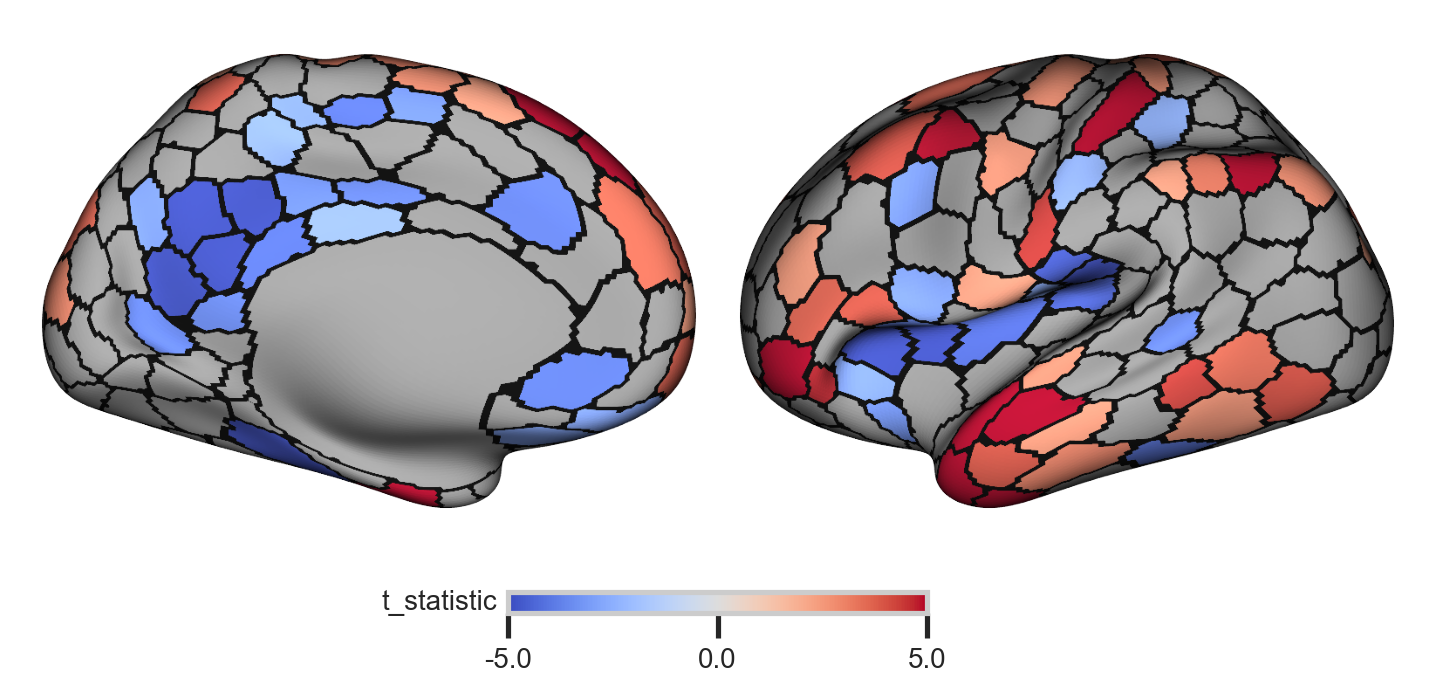

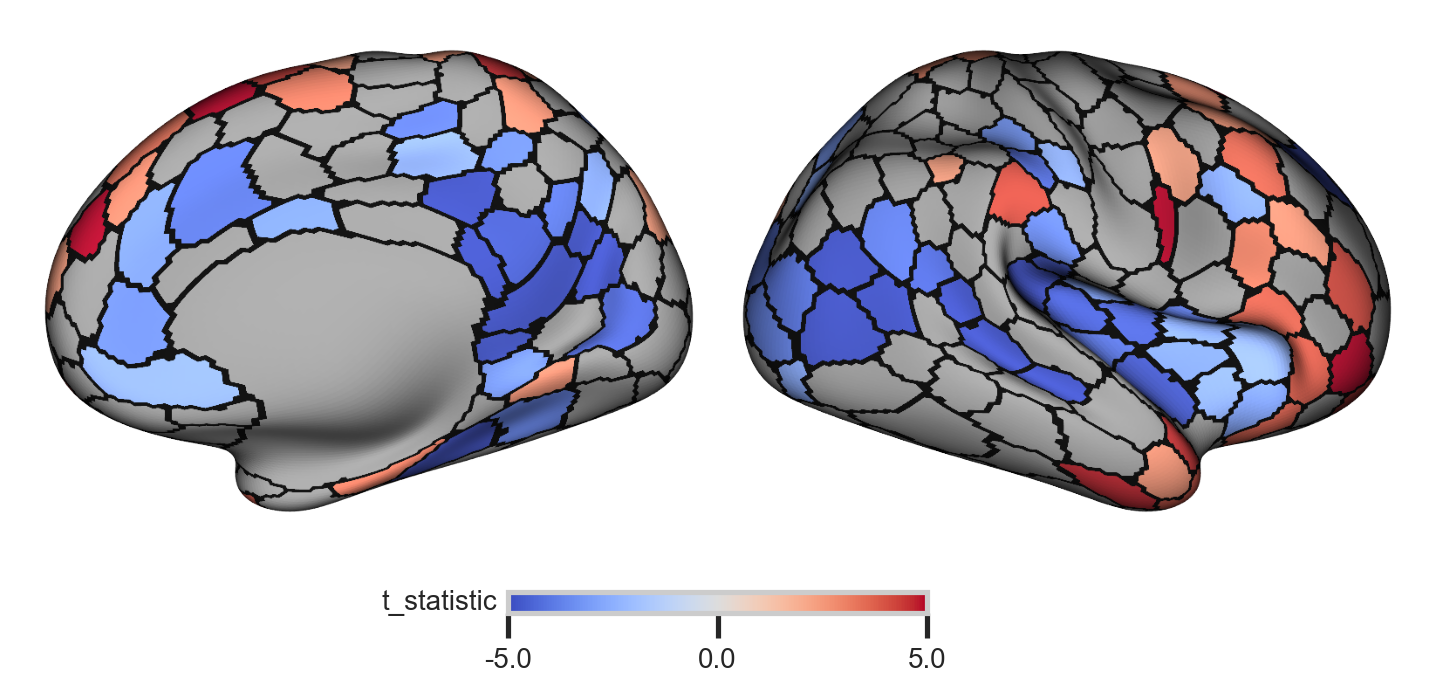

In [16]:
vmin = -5
vmax = 5

# Corrected loop for plotting each hemisphere independently
for hemi_key, hemi_surf_data, mapped_data, parcellation_data in zip(
    ["left", "right"],  # The key for surfplot's dictionary
    [lh, rh],  # The surface object for the current hemisphere
    [data_lh_mapped, data_rh_mapped],  # The mapped data for the current hemisphere
    [lh_parc, rh_parc],  # The parcellation for the current hemisphere
):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    pref_surf = {
        "surf_lh": hemi_surf_data if hemi_key == "left" else None,
        "surf_rh": hemi_surf_data if hemi_key == "right" else None,
    }
    p = Plot(
        **pref_surf,  # Unpack the surface dictionary
        views=["medial", "lateral"],  # Show both medial and lateral for this hemi
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",  # For a single hemisphere, row is fine
        mirror_views=False,  # Set to False, as we are plotting one hemi at a time
    )

    # ---- main data layer -------------------------------------------------
    # Pass only the data for the current hemisphere
    # The dictionary now contains only one key-value pair for the current hemisphere
    p.add_layer(
        {hemi_key: mapped_data},
        cmap="coolwarm",
        color_range=(vmin, vmax),  # Use symmetric range
        # norm=norm,  # Apply the symmetric normalization
        cbar_label=value_column,
        cbar=True,  # Ensure colorbar is shown for each plot if desired, or handle globally
    )
    # ---- outline layer ---------------------------------------------------
    p.add_layer({hemi_key: parcellation_data}, cmap="gray", as_outline=True, cbar=False)

    fig = p.build(
        # cbar_kws=dict(location="bottom", decimals=2, shrink=0.6)
    )  # Added cbar_kws for better cbar display

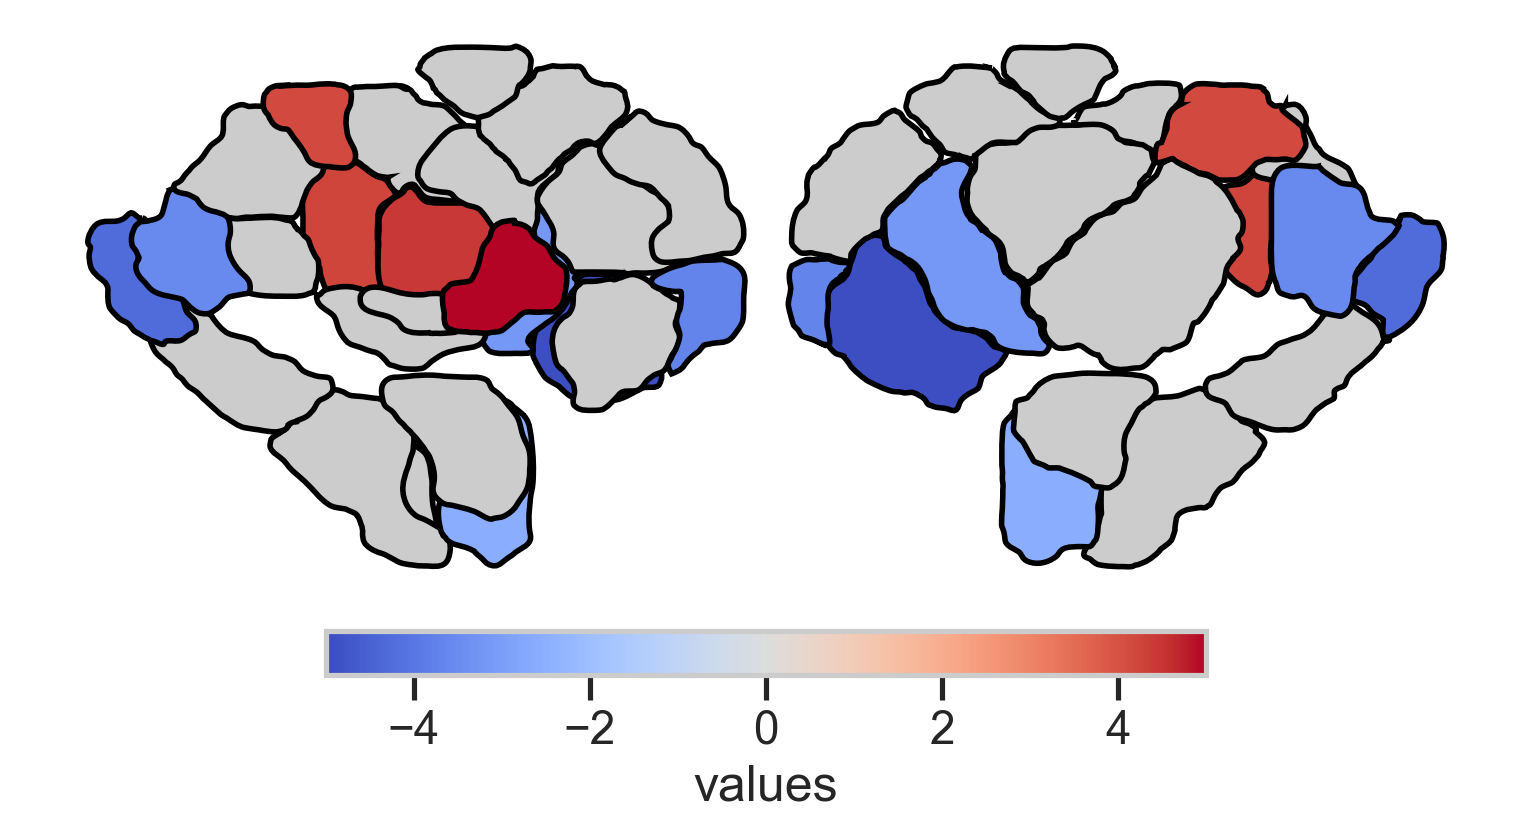

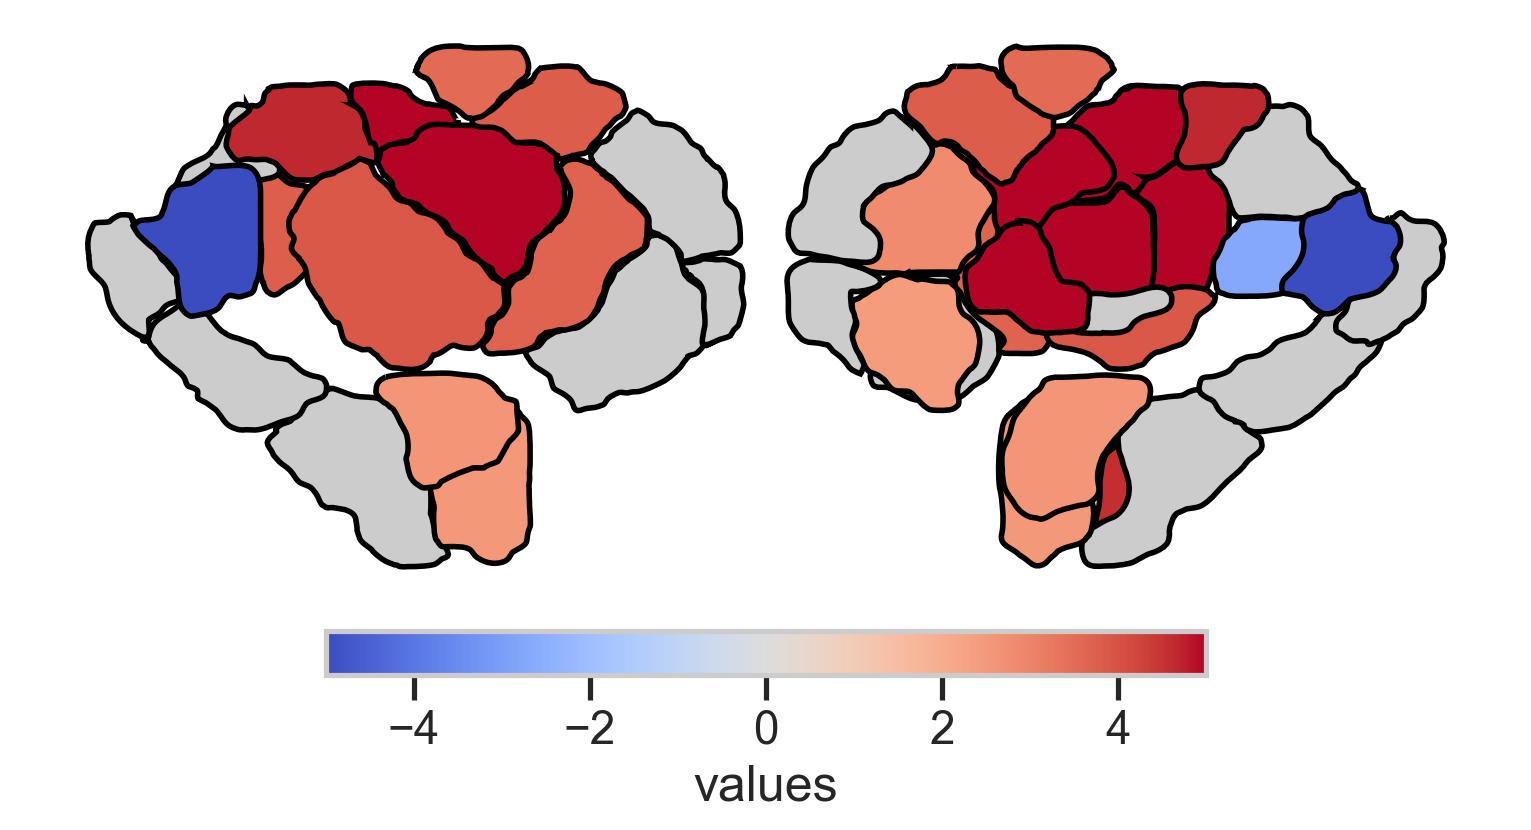

In [17]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L", "R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        cmap="coolwarm",
        line_color="black",
        line_thickness=2,
        vmin=vmin,
        vmax=vmax,
        show_figure=False,
    )

    # save figure
    # savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)